In [1]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 10.8 MB/s eta 0:00:00


In [2]:
# Gerekli kütüphaneler

import re  # Metin temizleme ve düzenli ifadeler için
import pandas as pd  # Veri tabanı işleme için
import matplotlib.pyplot as plt  # Görselleştirme için
import ipywidgets as widgets  # Interaktif bileşenler için
from IPython.display import display, clear_output  # Veri Setini Yükleme
from google.colab import files  # Google Colab üzerinden dosya yüklemek için
import stanza  # Türkçe için Stanza kütüphanesi

In [3]:
# Stanza'yı indirip başlatıyoruz
stanza.download('tr')  # Türkçe modelini indiriyoruz
nlp = stanza.Pipeline('tr')  # Türkçe dil işleme pipeline'ını başlatıyoruz

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: tr (Turkish) ...


INFO:stanza:Downloaded file to /root/stanza_resources/tr/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: tr (Turkish):
| Processor | Package       |
-----------------------------
| tokenize  | imst          |
| mwt       | imst          |
| pos       | imst_charlm   |
| lemma     | imst_nocharlm |
| depparse  | imst_charlm   |
| ner       | starlang      |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [15]:
# Veri Setini Yükleme.
from google.colab import files
uploaded = files.upload()

Saving Yemek_Veri_Tabanı.csv to Yemek_Veri_Tabanı (1).csv


In [17]:
# CSV dosyasını yükleyin
df = pd.read_csv('Yemek_Veri_Tabanı.csv')

# İlk 5 satırı inceleyin
df.head()

,Malzeme Adı,Porsiyon (g),Enerji (kcal),Yağ (g),Karbonhidrat (g),Protein (g),Şeker (g),Fiber (g)
0,Acur,100,23,0.18,5.16,0.72,4.62,0.8
1,Ahududu,100,52,0.65,11.94,1.20,4.42,6.5
2,Alabalık,100,138,5.40,0.00,20.87,0.00,0.0
3,Ananas,100,48,0.12,12.63,0.54,9.26,1.4
4,Andız Pekmezi,100,276,0.00,68.50,1.25,32.00,0.0


In [18]:
# Sütun adlarını kontrol edin
df.columns

Index(['Malzeme Adı', 'Porsiyon (g)', 'Enerji (kcal)', 'Yağ (g)',
       'Karbonhidrat (g)', 'Protein (g)', 'Şeker (g)', 'Fiber (g)'],
      dtype='object')

In [19]:
# Ölçü birimleri ve gram karşılıkları
olcu_birimleri = {
    "gram": 1,
    "gr": 1,
    "kg": 1000,
    "kilo":100,
    "kilogram": 1000,
    "litre": 1000,
    "li": 1000,
    "mililitre": 1,
    "ml": 1
}

In [20]:
# Lemmatizasyon işlemi için Stanza
def lemmatize_text(text):
    doc = nlp(text)  # Metni Stanza ile analiz et
    lemmatized_words = []
    for sent in doc.sentences:
        for word in sent.words:
            lemmatized_words.append(word.lemma)  # Lemma (kök) halini al
    return " ".join(lemmatized_words)  # Lemmatize edilmiş metni döndür

In [21]:
def malzeme_ve_miktar_bul(metin):
    """
    Tarif metninden malzemeleri ve miktarları ayıklar.
    """
    # Metni küçük harfe çevirme ve gereksiz karakterleri kaldırma
    metin = re.sub(r'[^\w\s]', '', metin.lower())

    # Lemmatize işlemi uyguluyoruz
    metin = lemmatize_text(metin)  # Stanza ile metni kök hale getiriyoruz (lemmatization).

    malzemeler = []  # Malzemeleri tutacak bir liste oluşturuyoruz.

    for birim, gram_katsayi in olcu_birimleri.items():  # Ölçü birimleri ve gram karşılıklarını içeren sözlükte dönüyoruz.
        # Ölçü birimi ve malzeme adlarını yakalamak için düzenli ifade (regex) deseni oluşturuyoruz.
        pattern = rf"(\d+)\s*{birim}\s+(\w+)"

        eslesmeler = re.findall(pattern, metin)  # Bu deseni metinde arıyoruz ve eşleşenleri buluyoruz.

        # Eşleşen her miktar ve malzeme için işlemler yapıyoruz
        for miktar, malzeme in eslesmeler:
            miktar_gram = int(miktar) * gram_katsayi  # Miktarı, ölçü biriminin gram karşılığı ile çarpıyoruz.
            malzemeler.append({"Malzeme": malzeme, "Miktar (g)": miktar_gram})  # Bulunan malzeme ve miktarı listeye ekliyoruz.

    return pd.DataFrame(malzemeler)  # Sonuçları bir DataFrame olarak döndürüyoruz.

In [22]:
def besin_degerleri_hesapla(malzemeler, veri_tabanı):
    """
    Malzeme listesini veri tabanı ile eşleştirir ve toplam besin değerlerini hesaplar.
    """
    # Toplam besin değerlerini sıfırdan başlatıyoruz
    toplam_besinler = {"Enerji (kcal)": 0, "Yağ (g)": 0, "Karbonhidrat (g)": 0, "Protein (g)": 0, "Şeker (g)":0, "Fiber (g)":0 }

    # Malzeme listesindeki her bir malzeme için işlem yapıyoruz
    for _, malzeme in malzemeler.iterrows():  # Her malzeme satırını alıyoruz.
        # Veri tabanındaki malzeme ile eşleşen kayıtları arıyoruz
        veri = veri_tabanı[veri_tabanı['Malzeme Adı'].str.contains(malzeme["Malzeme"], case=False)]
        # Eğer veri bulunduysa, besin değerlerini hesaplıyoruz
        if not veri.empty:
            miktar_carpani = malzeme["Miktar (g)"] / 100  # Miktarı gram cinsine çeviriyoruz (100g'lık bazda).

            # Her besin değeri için ilgili veriyi hesaplıyoruz
            toplam_besinler["Enerji (kcal)"] += veri.iloc[0]["Enerji (kcal)"] * miktar_carpani
            toplam_besinler["Yağ (g)"] += veri.iloc[0]["Yağ (g)"] * miktar_carpani
            toplam_besinler["Karbonhidrat (g)"] += veri.iloc[0]["Karbonhidrat (g)"] * miktar_carpani
            toplam_besinler["Protein (g)"] += veri.iloc[0]["Protein (g)"] * miktar_carpani
            toplam_besinler["Şeker (g)"] += veri.iloc[0]["Şeker (g)"] * miktar_carpani
            toplam_besinler["Fiber (g)"] += veri.iloc[0]["Fiber (g)"] * miktar_carpani

    return toplam_besinler  # Hesaplanan toplam besin değerlerini döndürüyoruz

In [23]:
def besin_degerlerini_gorsellestir(besinler):
    """
    Besin değerlerini pasta grafiği ile görselleştirir.
    """
    etiketler = list(besinler.keys())
    degerler = list(besinler.values())

    plt.figure(figsize=(8, 8))
    plt.pie(degerler, labels=etiketler, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title("Toplam Besin Değerleri Dağılımı")
    plt.show()


Ayıklanan Malzemeler ve Gramajları:
     Malzeme  Miktar (g)
0      şeker         250
1   kabartma          10
2    vanilya          10
3         un         500
4  zeytinyak         125
5        süt         250

Toplam Besin Değerleri:
Enerji (kcal): 3960.00
Yağ (g): 144.00
Karbonhidrat (g): 619.58
Protein (g): 67.50
Şeker (g): 255.77
Fiber (g): 85.00


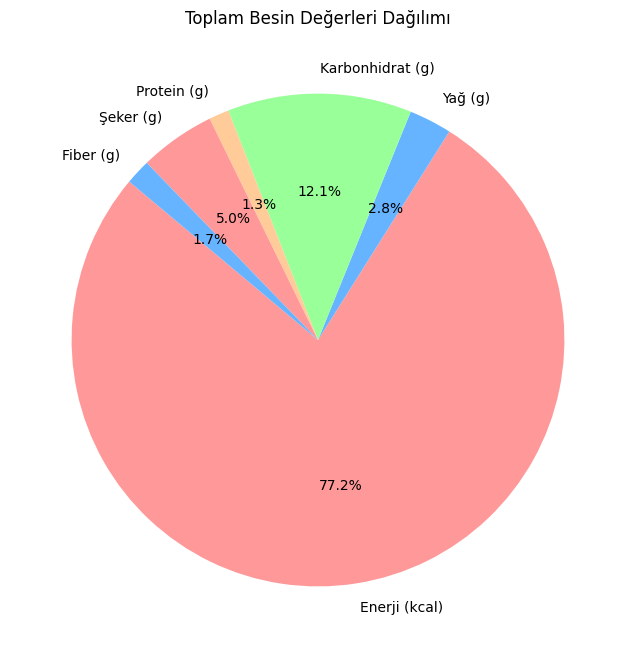

In [24]:
# Ölçü birimlerinin açıklamasını yazıyoruz
olcu_birimi_aciklama = """
Lütfen Tarif Yazarken Bu Birimleri Kullanınız:
gram, gr, kg, kilo, kilogram, litre, li, mililitre, ml
"""
olcu_birimi_label = widgets.Label(value=olcu_birimi_aciklama)  # Etiket widget'ı oluşturuyoruz

# Ölçü birimi açıklamasını ekrana yazdırıyoruz
display(olcu_birimi_label)

# Tarif metni için bir metin alanı widget'ı oluşturuyoruz
tarif_metni_widget = widgets.Textarea(
    value='',  # Başlangıçta boş bir değer
    placeholder='Tarif metnini buraya yazın',  # Kullanıcıya yardımcı metin
    description='Tarif Metni:',  # Metin alanının başlığı
    disabled=False  # Kullanıcı metni yazabilsin
)

# Bir buton widget'ı oluşturuyoruz
buton_widget = widgets.Button(description="Hesapla")  # Butonun başlığı "Hesapla"

# Butona tıklama fonksiyonu
def on_button_click(b):
    # Önceki çıktı ve grafikleri temizliyoruz
    clear_output(wait=True)

    # Kullanıcı tarafından girilen tarif metnini alıyoruz
    tarif_metni = tarif_metni_widget.value

    # Tarif metninden malzemeleri ve miktarları ayıklıyoruz
    malzeme_df = malzeme_ve_miktar_bul(tarif_metni)

    # Eğer malzemeler boşsa (yani doğru ölçü birimi bulunmadıysa), kullanıcıya uyarı veriyoruz
    if malzeme_df.empty:
        print("Yanlış Ölçü Birimi Girdiniz ya da Malzeme Bulunamadı. Lütfen Tekrar Deneyiniz.")
        return

    # Ayıklanan malzemelerle toplam besin değerlerini hesaplıyoruz
    toplam_besin_degerleri = besin_degerleri_hesapla(malzeme_df, df)

    # Ekrana ayıklanan malzemeleri ve gramajlarını yazdırıyoruz
    print("\nAyıklanan Malzemeler ve Gramajları:")
    print(malzeme_df)

    # Ekrana toplam besin değerlerini yazdırıyoruz
    print("\nToplam Besin Değerleri:")
    for besin, deger in toplam_besin_degerleri.items():
        print(f"{besin}: {deger:.2f}")  # Besin değerlerini iki ondalıklı şekilde yazdırıyoruz

    # Besin değerlerini görselleştiriyoruz
    besin_degerlerini_gorsellestir(toplam_besin_degerleri)

# Buton ile on_button_click işlevini ilişkilendiriyoruz
buton_widget.on_click(on_button_click)

# Bileşenleri (metin alanı ve buton) ekrana yazdırıyoruz
display(tarif_metni_widget)
display(buton_widget)